In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Introduction
I will be using the CES11 data from R datasets. This is part of a survey on canadian voters on whether or not they
support banning abortion. This data set is all categorical except for one column, population which contains information on
the population of the city or province the respondent lives in. The other non categorical column is the weight column, which
contains values representing weight sample to size of population, taking into account unequal sampling probabilities by
province and household size. For the purposes of this analysis we won't worry about that one.

In [62]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/carData/CES11.csv"
CES11_df = pd.read_csv(url)

## Exploring the data

In [63]:
print(CES11_df.describe)
print(CES11_df.size)
print(CES11_df.dtypes)

<bound method NDFrame.describe of       Unnamed: 0    id province  population   weight  gender abortion  \
0              1  2851       BC     3267345  4287.85  Female       No   
1              2   521       QC     5996930  9230.78    Male       No   
2              3  2118       QC     5996930  6153.85    Male      Yes   
3              4  1815       NL      406455  3430.00  Female       No   
4              5  1799       ON     9439960  8977.61    Male       No   
...          ...   ...      ...         ...      ...     ...      ...   
2226        2227   490       MB      871460  8743.75  Female       No   
2227        2228   781       QC     5996930  6153.85  Female       No   
2228        2229   671       QC     5996930  6153.85    Male       No   
2229        2230  2488       BC     3267345  4287.85  Female       No   
2230        2231  1368       MB      871460  5829.16    Male       No   

     importance  education  urban  
0      somewhat     somePS  urban  
1           not  

## Cleaning the data
Drop the unnamed category, this is going to create an issue later. We are also going to drop the id column, since this
column isn't going to give us any additional information and might confuse whatever model we use in the future.
Since most of the categories are categorical we will convert these to a integer representation, to make using in machine learning models easier.

In [64]:
CES11_df.drop('Unnamed: 0', axis=1, inplace=True)
CES11_df.drop('id', axis=1, inplace=True)

In [65]:
CES11_df_2 = CES11_df.replace({'province' :{'AB':0,'BC':1,'MB':2,'NB':3,'NL':4,'NS':5,'ON':6,'PE':7,'QC':8,'SK':9},
                             'gender':{'Male':0, 'Female':1},
                             'importance' : {'not':0,'notvery':1,'somewhat':2,'very':3},
                             'education' : {'bachelors':0,'college':1, 'higher':2, 'HS' :3, 'lessHS':4,'somePS':5},
                             'urban' : {'urban' : 0,'rural' :1}})
CES11_df_2.describe

<bound method NDFrame.describe of      province  population   weight  gender abortion importance  education  \
0          BC     3267345  4287.85  Female       No   somewhat     somePS   
1          QC     5996930  9230.78    Male       No        not  bachelors   
2          QC     5996930  6153.85    Male      Yes   somewhat    college   
3          NL      406455  3430.00  Female       No       very     somePS   
4          ON     9439960  8977.61    Male       No        not     higher   
...       ...         ...      ...     ...      ...        ...        ...   
2226       MB      871460  8743.75  Female       No   somewhat    college   
2227       QC     5996930  6153.85  Female       No   somewhat     somePS   
2228       QC     5996930  6153.85    Male       No   somewhat     higher   
2229       BC     3267345  4287.85  Female       No        not     higher   
2230       MB      871460  5829.16    Male       No        not         HS   

      urban  
0     urban  
1     urban  

After cleaning the data we are left with a data frame of 2231 rows and 8 columns. Our
target will be the abortion column, and the features will be everything else.

## Visualize the data
Let's Visualize our data. The plan is to make a model to predict whether a Canadian voter supports or opposes
banning abortion, so that will be our hue.

<AxesSubplot:>

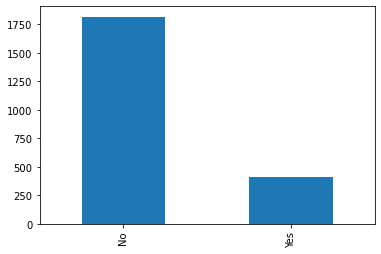

In [66]:
CES11_df_2['abortion'].value_counts().plot(kind='bar')

This is a hugely imbalanced dataset, no's makeup about 80% of the dataset. This means it is going to be a little more
difficult to make a machine learning model better than simply pure guessing. Let's go a step further and look at the
pair plot

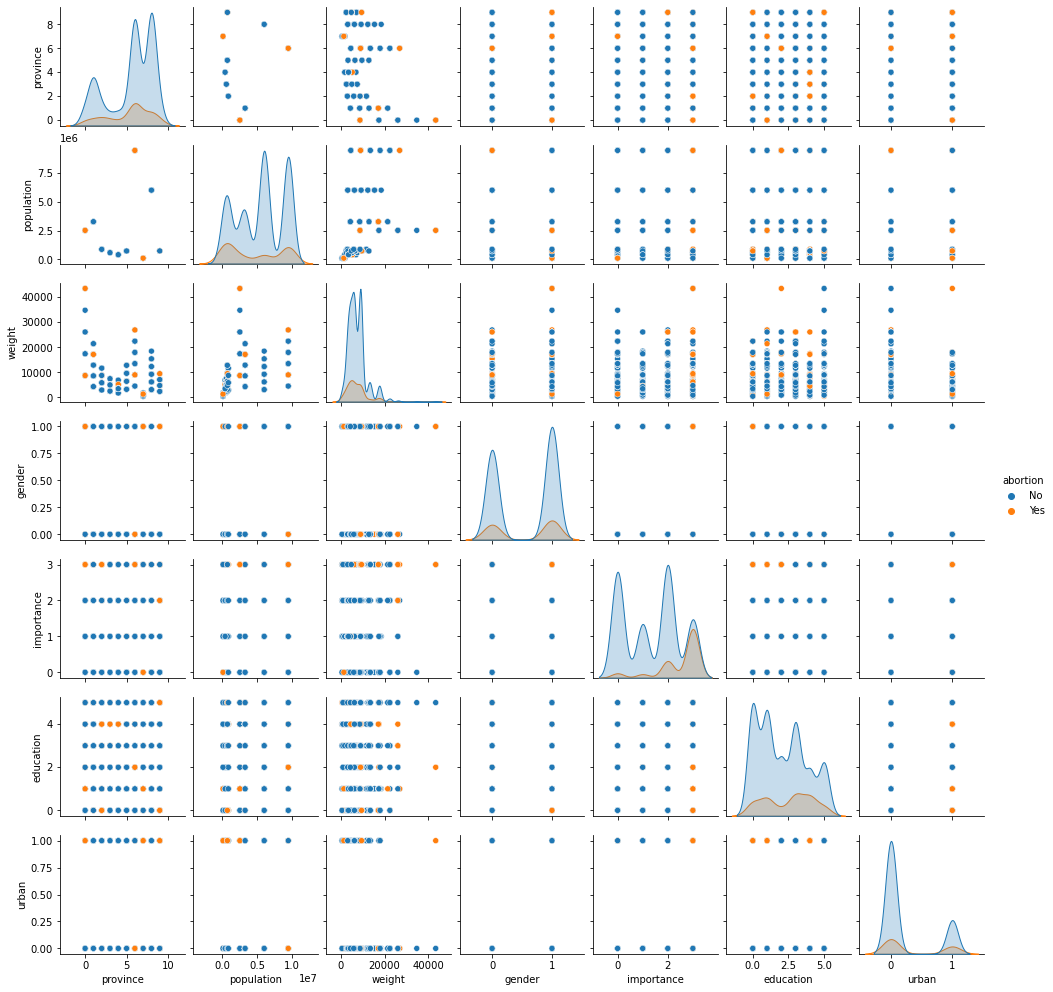

In [67]:
sns.pairplot(CES11_df_2, hue='abortion', height=2)

In addition to the imbalance of the abortion column, there are not a lot of clear places we could draw a clear dividing
line without potentially over fitting our data

## Next Steps
After looking at the summary statistics for the dataset I have a couple questions I think we could potentially answer.
The first is whether a particular characteristic is valuable for predicting a person's stance on banning abortion.
To solve this question I think a decision tree would be the best model to use, because we can very clearly see the
columns the model is using. I would also like to test this on an SVM. Because this is a difficult data set interms of balance
I would like to see which model performs better.

### Question 1: Can we predict whether a respondent supports Abortion or not using a decision tree?

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score
from treeprint import tree_print
from confidence import classification_confint
from sklearn.metrics import confusion_matrix

In [69]:
targets = pd.DataFrame(CES11_df_2['abortion'])
features = CES11_df_2.drop('abortion', axis=1)

In [70]:
model = model = tree.DecisionTreeClassifier()
param_grid = {
    'max_depth': list(range(1,11)), # search 1..10
    'criterion': ['entropy', 'gini']
    }
grid = GridSearchCV(model, param_grid, cv=5)

In [71]:
grid.fit(features,targets)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [72]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': 2}


In [73]:
print("Best tree:")
tree_print(grid.best_estimator_,features)

Best tree:
if importance =< 2.5: 
  |then if importance =< 1.5: 
  |  |then No
  |  |else No
  |else if population =< 2891262.5: 
  |  |then Yes
  |  |else No
<---->
Tree Depth:  2


In [74]:
predict_target = grid.best_estimator_.predict(features)

In [75]:
acc = accuracy_score(targets, predict_target)

In [76]:
observations = CES11_df_2.shape[0]
lb,ub = classification_confint(acc, observations)
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

# buld confusion matrix
labels = ['No', 'Yes']
cm2 = confusion_matrix(targets, predict_target, labels=labels)
cm_df2 = pd.DataFrame(cm2, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df2))

Accuracy: 0.83 (0.82,0.85)
Confusion Matrix:
       No  Yes
No   1723   95
Yes   278  135


Our model is between 82 and 85 percent accurate which is
fairly successful in my opinion especially considering the
lack of clear divides in this situation.
Going further the model found that we could be successful in
predicting with only two variables, how important is abortion to the respondent,
and the population of the province they come from.

### Question 2: Will an SVM do this classification better?

In [77]:
from sklearn.svm import SVC


In [78]:
# SVM 2
model2 = SVC(kernel='poly', C=0.010, degree=4, coef0=1.0, max_iter=10000)
param_grid2 = [{'C': [1, 10, 100, 1000], 'kernel': ['poly']},
               {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]
grid2 = GridSearchCV(model2, param_grid2, cv=5)
grid2.fit(features, targets)
print("Grid Search: best parameters: {}".format(grid2.best_params_))

C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

Grid Search: best parameters: {'C': 1, 'kernel': 'poly'}


C:\Users\nickp\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\nickp\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

In [79]:
# evaluate the best model
best_model2 = grid2.best_estimator_
predict_y2 = best_model2.predict(features)
acc2 = accuracy_score(targets, predict_y2)
lb2,ub2 = classification_confint(acc2,features.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc2,lb2,ub2))

# build confusion matrix
labels = ['No', 'Yes']
cm2 = confusion_matrix(targets, predict_y2, labels=labels)
cm_df2 = pd.DataFrame(cm2, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df2))

Accuracy: 0.81 (0.80,0.83)
Confusion Matrix:
       No  Yes
No   1818    0
Yes   413    0


### Analysis
These results are interesting for a couple of reasons.
The first is that the decision tree was ultimately a better predictor of whether a canadian voter supports
abolishing abortion or not. The difference was not statistically significant because there was overlap with the confidence interval,
 but the difference was in the confusion matrix. The SVM simply always guessed No, and was right 81% of the time because of
 the imbalance in the dataset. The decision tree could be better over a larger more balanced data set because it had an
 actual set of rules, and did not over fit to the input data.